# Comparison of TMVA and Scikit-Learn
- Find out how the BDT scores in TMVA and SKLearn differ

# Standard imports

In [1]:
import sklearn
print(sklearn.__version__)
import numpy
print("numpy-version: "+numpy.__version__)
import scipy
print("scipy-version: "+scipy.__version__)
!python --version

0.20.3
numpy-version: 1.14.2
scipy-version: 1.1.0
Python 3.6.5


In [2]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame
import root_pandas

Welcome to JupyROOT 6.14/04


In [3]:
df_mc=pd.read_hdf('/eos/user/j/jglatzer/L2Output_R20_Nov_v2_pandaspython3/pandas_INC_ge6jge4b.h5', 'INC_ge6jge4b')
signalmask=df_mc.process.apply(lambda x: True if "Hp" in x else False)
df_mc_signal=df_mc[signalmask]
#df_mc_signal.to_root('events6j4b_signal.root', key='signal_6j4b')
df_mc_background=df_mc[~signalmask]
#df_mc_background.to_root('events6j4b_background.root', key='background_6j4b')
#print(df_mc_signal.process.unique(),df_mc_background.process.unique())

## Building of the Ensemble

BDTs are based on training $n_{estimators}$ decision trees. The final score is then
- scikit-learn: $\mathrm{score}(X)=\sum\limits_{i=0}^{n_{estimators}} \alpha_{LR} \cdot f_i(X) + f_{-1}(X)$
- TMVA: $\mathrm{score}(X)=\mathrm{Sig}\left(\sum\limits_{i=0}^{n_{estimators}} f_i(X)\right)$

where
- $f_i(X)$ is the output of tree $i$
- $\alpha_{LR}$ is the learning rate
- $f_{-1}(X)$ is the LogOddsEstimator, i.e. $\mathrm{log}(n_{S}/n_{B})$, where $n_S$ is the sum of weights for signal and $n_B$ for background
- $\mathrm{Sig}(x)=\frac{2}{1+\mathrm{exp}(-2\cdot x)}-1$ a function that squeezes the result into $\left[-1,1\right]$

for any training data that is converted from SKLearn to TMVA using skTMVA (https://github.com/yuraic/koza4ok/tree/master/skTMVA) only these transformations need to be applied. Training in TMVA and SKLearn still differ due to 1. different random seeds and 2. different training procedure for individual trees.

```
Double_t TMVA::MethodBDT::GetGradBoostMVA(TMVA::Event& e, UInt_t nTrees)        
{                                                                               
  //returns MVA value: -1 for background, 1 for signal                         
  Double_t sum=0;                                                              
  for (UInt_t itree=0; itree<nTrees; itree++) {                                
     //loop over all trees in forest                                           
     sum += fForest[itree]->CheckEvent(e,kFALSE);                              
                                                                                
   }                                                                            
  return 2.0/(1.0+exp(-2.0*sum))-1; //MVA output between -1 and 1              
}
```

In [5]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
htf.feature_names=["pT_jet1","Mbb_MindR_70"]
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=300)

### let's check this

In [6]:
n_estimators=10

htf=HpTrainingFrame.HpTrainingFrame(df_mc)
htf.feature_names=["pT_jet1","Mbb_MindR_70"]
from sklearn.ensemble import GradientBoostingClassifier
bdt = GradientBoostingClassifier(n_estimators=n_estimators,
                                 learning_rate=0.13,
                                 max_depth=2,
                                 min_weight_fraction_leaf=0.01,
                                 random_state=0)
bdt.fit(X_train, y_train)

from skTMVA import convert_bdt_sklearn_tmva
convert_bdt_sklearn_tmva(bdt, [("pT_jet1","F"),("Mbb_MindR_70","F")], 'bdt.xml')

first the results for TMVA

In [7]:
import ROOT
from ROOT import TFile, TMVA

reader=TMVA.Reader("silent")
import array
variables={}
for name in htf.feature_names:
    variables[name] = array.array('f',[0])
    reader.AddVariable(name,variables[name])

reader.BookMVA('BDT300', 'bdt.xml')

for ievt in range(0,10):
    variables['pT_jet1'][0]=X_train.values[ievt,0]
    variables['Mbb_MindR_70'][0]=X_train.values[ievt,1]
    #print(variables)
    print(reader.EvaluateMVA('BDT300'))#, reader.GetRarity('BDT300'),reader.GetProba('BDT300'))

0.7863780660348862
0.8505963930838072
0.8505963930838072
0.6810659581156862
-0.9981318033765185
0.7863780660348862
-0.999010550553052
-0.9501629879283715
-0.9277658417463568
0.9830166635861586


now the results for SKLearn

In [8]:
def decfunc2TMVA(clf, X):
    bdtdf=(clf.decision_function(X)[:]-clf._init_decision_function(X)[:,0])/bdt.get_params()['learning_rate']
    return 2/(1+np.exp(-2*bdtdf))-1

In [9]:
for i in decfunc2TMVA(bdt, X_train.values[:10]):
    print(i)

0.7863780697661387
0.8505963961217635
0.8505963961217635
0.6810659624936779
-0.9981318033894181
0.7863780697661387
-0.9990105505412923
-0.9501629873172747
-0.9277658416880953
0.9830166644102563


Hey, it's all working nicely

## Training of the individual trees

# create a TMVA BDT score

In [49]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
htf.feature_names=["pT_jet1","Mbb_MindR_70"]
#htf.feature_names

In [52]:
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=300)
variables={}
for i,name in enumerate(X_train.columns):
    variables[name]=float(X_train.values[0,i])
print(X_train.columns)
print(X_train.values[0,:])
print(variables)

Index(['pT_jet1', 'Mbb_MindR_70'], dtype='object')
[145381.546875 133034.546875]
{'pT_jet1': 145381.546875, 'Mbb_MindR_70': 133034.546875}


create a simple SKL clf

In [173]:
from sklearn.ensemble import GradientBoostingClassifier
bdt = GradientBoostingClassifier(n_estimators=2,
                                 learning_rate=0.13,
                                 max_depth=2,
                                 min_weight_fraction_leaf=0.01,
                                 random_state=0)
bdt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.13, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=2,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [174]:
from skTMVA import convert_bdt_sklearn_tmva
convert_bdt_sklearn_tmva(bdt, [("pT_jet1","F"),("Mbb_MindR_70","F")], 'bdt.xml')

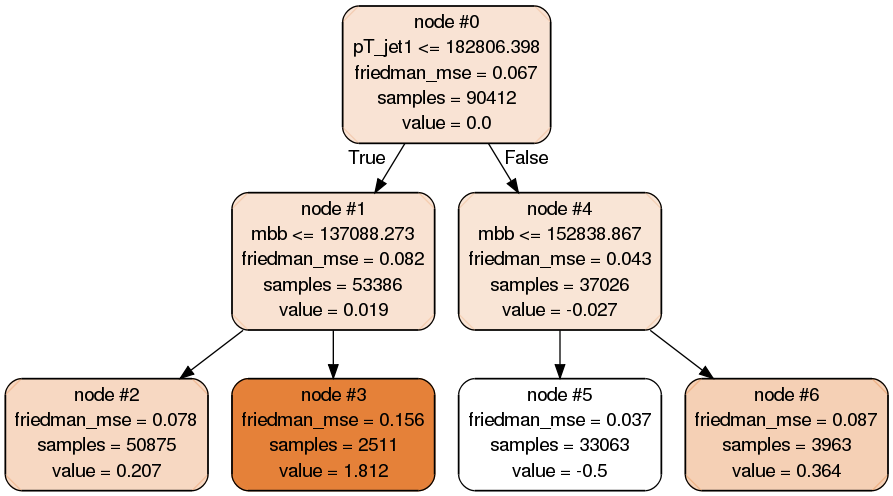

In [135]:
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image, display, SVG
import pydotplus


sub_tree_0 = bdt.estimators_[0, 0]

#dot_data = StringIO()
export_graphviz(sub_tree_0, out_file="tree.dot", feature_names=["pT_jet1","mbb"],
                filled=True, rounded=True,
                special_characters=False, node_ids=True, impurity=True)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [130]:
X_train.groupby(y_train).count()

,pT_jet1,Mbb_MindR_70
process,,
0,83914,83914
1,6498,6498


In [110]:
X_train[X_train.pT_jet1<=182806.386].groupby(y_train).count()

,pT_jet1,Mbb_MindR_70
process,,
0,48543,48543
1,4843,4843


In [129]:
print(sub_tree_0)
print(sub_tree_0.tree_)
estimator=sub_tree_0
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold
print(n_nodes)
print(children_left)
print(children_right)
print(feature)
print(threshold)
print(estimator.tree_.value)
print("predict:",estimator.tree_.impurity)
dir(estimator.tree_)
#value = tree.value[node_id]
#'child_left': dtree.tree_.children_left,
#            'child_right': dtree.tree_.children_right,
#            'feature': dtree.tree_.feature,
#            'threshold': dtree.tree_.threshold,

DecisionTreeRegressor(criterion='friedman_mse', max_depth=2,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.01, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f0aa3f6f900>,
           splitter='best')
7
[ 1  2 -1 -1  5 -1 -1]
[ 4  3 -1 -1  6 -1 -1]
[ 0  1 -2 -2  1 -2 -2]
[ 1.82806398e+05  1.37088273e+05 -2.00000000e+00 -2.00000000e+00
  1.52838867e+05 -2.00000000e+00 -2.00000000e+00]
[[[ 1.66293388e-17]]

 [[ 1.88456767e-02]]

 [[ 2.07023236e-01]]

 [[ 1.81215654e+00]]

 [[-2.71726705e-02]]

 [[-4.99785870e-01]]

 [[ 3.63812267e-01]]]
predict: [0.06670555 0.08248715 0.07833943 0.1555986  0.04270038 0.03704775
 0.08689653]


['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'apply',
 'capacity',
 'children_left',
 'children_right',
 'compute_feature_importances',
 'decision_path',
 'feature',
 'impurity',
 'max_depth',
 'max_n_classes',
 'n_classes',
 'n_features',
 'n_node_samples',
 'n_outputs',
 'node_count',
 'predict',
 'threshold',
 'value',
 'weighted_n_node_samples']

In [104]:
X=X_train.values[0:10,:]
print(bdt._init_decision_function(X))
print(X)
print(bdt.decision_function(X))
print(bdt.estimators_[0, 0].predict(X))
print(bdt.estimators_)
(bdt.decision_function(X)-bdt._init_decision_function(X))/bdt.estimators_[0, 0].predict(X)

[[-2.55829803]
 [-2.55829803]
 [-2.55829803]
 [-2.55829803]
 [-2.55829803]
 [-2.55829803]
 [-2.55829803]
 [-2.55829803]
 [-2.55829803]
 [-2.55829803]]
[[145381.546875   133034.546875  ]
 [433351.84375     89065.6875    ]
 [119276.515625    60938.44921875]
 [374073.09375    152912.265625  ]
 [123602.9296875   45375.62109375]
 [122919.2421875   71832.5625    ]
 [113391.6171875  104772.6015625 ]
 [218802.140625    72405.2265625 ]
 [186182.34375     83443.90625   ]
 [113414.7265625   55452.453125  ]]
[-2.53138501 -2.62327019 -2.53138501 -2.51100243 -2.53138501 -2.53138501
 -2.53138501 -2.62327019 -2.62327019 -2.53138501]
[ 0.20702324 -0.49978587  0.20702324  0.36381227  0.20702324  0.20702324
  0.20702324 -0.49978587 -0.49978587  0.20702324]
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=2,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_f

array([[0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]])

In [172]:
bdt.

1.0043016091968684

In [175]:
import ROOT
from ROOT import TFile, TMVA

reader=TMVA.Reader("silent")
import array
variables={}
for name in htf.feature_names:
    variables[name] = array.array('f',[0])
    reader.AddVariable(name,variables[name])
    #vary = array.array('f',[0]) ; reader.AddVariable("y",vary)

#reader.AddVariable(var, &m_variableMap[var])
reader.BookMVA('BDT300', 'bdt.xml')
print(X_train.values[0,:])
def TMVA2SKL(y):
    return 0.5*np.log((y+1)/(1-y))

for ievt in range(0,10):
    variables['pT_jet1'][0]=X_train.values[ievt,0]
    variables['Mbb_MindR_70'][0]=X_train.values[ievt,1]
    print(variables)
    print(reader.EvaluateMVA('BDT300'), reader.GetRarity('BDT300'),reader.GetProba('BDT300'))

[145381.546875 133034.546875]
{'pT_jet1': array('f', [145381.546875]), 'Mbb_MindR_70': array('f', [133034.546875])}
0.41095744083053587 0.0 -1.0
{'pT_jet1': array('f', [433351.84375]), 'Mbb_MindR_70': array('f', [89065.6875])}
-0.7242709187754054 0.0 -1.0
{'pT_jet1': array('f', [119276.515625]), 'Mbb_MindR_70': array('f', [60938.44921875])}
0.41095744083053587 0.0 -1.0
{'pT_jet1': array('f', [374073.09375]), 'Mbb_MindR_70': array('f', [152912.265625])}
0.572353731699595 0.0 -1.0
{'pT_jet1': array('f', [123602.9296875]), 'Mbb_MindR_70': array('f', [45375.62109375])}
0.41095744083053587 0.0 -1.0
{'pT_jet1': array('f', [122919.2421875]), 'Mbb_MindR_70': array('f', [71832.5625])}
0.41095744083053587 0.0 -1.0
{'pT_jet1': array('f', [113391.6171875]), 'Mbb_MindR_70': array('f', [104772.6015625])}
0.41095744083053587 0.0 -1.0
{'pT_jet1': array('f', [218802.140625]), 'Mbb_MindR_70': array('f', [72405.2265625])}
-0.7242709187754054 0.0 -1.0
{'pT_jet1': array('f', [186182.34375]), 'Mbb_MindR_70'

In [199]:
print(decfunc2TMVA(bdt, X_train.values[:10]))


bdt._init_decision_function(X_train.values[:10]).shape

(10,)
(10,)
(10,)
[ 0.41095744 -0.72427092  0.41095744  0.57235373  0.41095744  0.41095744
  0.41095744 -0.72427092 -0.72427092  0.41095744]


(10, 1)

Convert the SKL training to TMVA with skTMVA

In [13]:
from skTMVA import convert_bdt_sklearn_tmva
from joblib import load
clf=load('standardBDT_300.joblib')
variables=[]
for name in htf.feature_names:
    variables.append((name, 'F'))
convert_bdt_sklearn_tmva(clf, variables, 'bdt_sklearn_to_tmva_standardBDT_300.xml')

In [16]:
import ROOT
from ROOT import TFile, TMVA

reader=TMVA.Reader("silent")
import array
variables={}
for name in htf.feature_names:
    variables[name] = array.array('f',[0])
    reader.AddVariable(name,variables[name])
    #vary = array.array('f',[0]) ; reader.AddVariable("y",vary)

#reader.AddVariable(var, &m_variableMap[var])
reader.BookMVA('BDT300', 'bdt_sklearn_to_tmva_standardBDT_300.xml')
variables
print reader.EvaluateMVA('BDT300')

#Double_t 	GetProba (const TString &methodTag, Double_t ap_sig=0.5, Double_t mvaVal=-9999999)
# 	evaluates probability of MVA for given set of input variables More...
# 
#Double_t 	GetRarity (const TString &methodTag, Double_t mvaVal=-9999999)

#outputFile = TFile( "TMVA.root", 'RECREATE' )
#TMVA.Tools.Instance();

#factory = TMVA.Factory( "TMVAClassification", outputFile #this is optional
#                       ,"!V:Color:DrawProgressBar:Transformations=I;D;P;G,D:AnalysisType=Classification" )

<ROOT.TMVA::MethodBDT object ("BDT") at 0x14291f10>

# Old Stuff

In [10]:
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

In [8]:
importlib.reload(HpTrainingFrame)

<module 'HpTrainingFrame' from '/eos/home-j/jglatzer/SWAN_projects/HPML/HpTrainingFrame.py'>

In [9]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc)

In [28]:
from joblib import load
clf=load('massparameterisedBDT.joblib')
X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval =htf.prepare(hpmass="multi", addMass=True, invertsignal=False, absoluteWeight=False)
decfunc=clf.decision_function(X_train)

train_decfunc=pd.concat([X_train.hpmass,pd.Series(decfunc, index=X_train.index), w_train],axis=1)
train_decfunc.columns = ['hpmass', 'decfunc','weight']
decfunc=clf.decision_function(X_test)
score=clf.score(X_test)
test_decfunc=pd.concat([X_test.hpmass,pd.Series(decfunc, index=X_test.index), w_test],axis=1)
test_decfunc.columns = ['hpmass', 'decfunc','weight']
#print np.min(w_train), np.max(w_train),np.min(w_test), np.max(w_test)

## first plot a histogram of all distributions

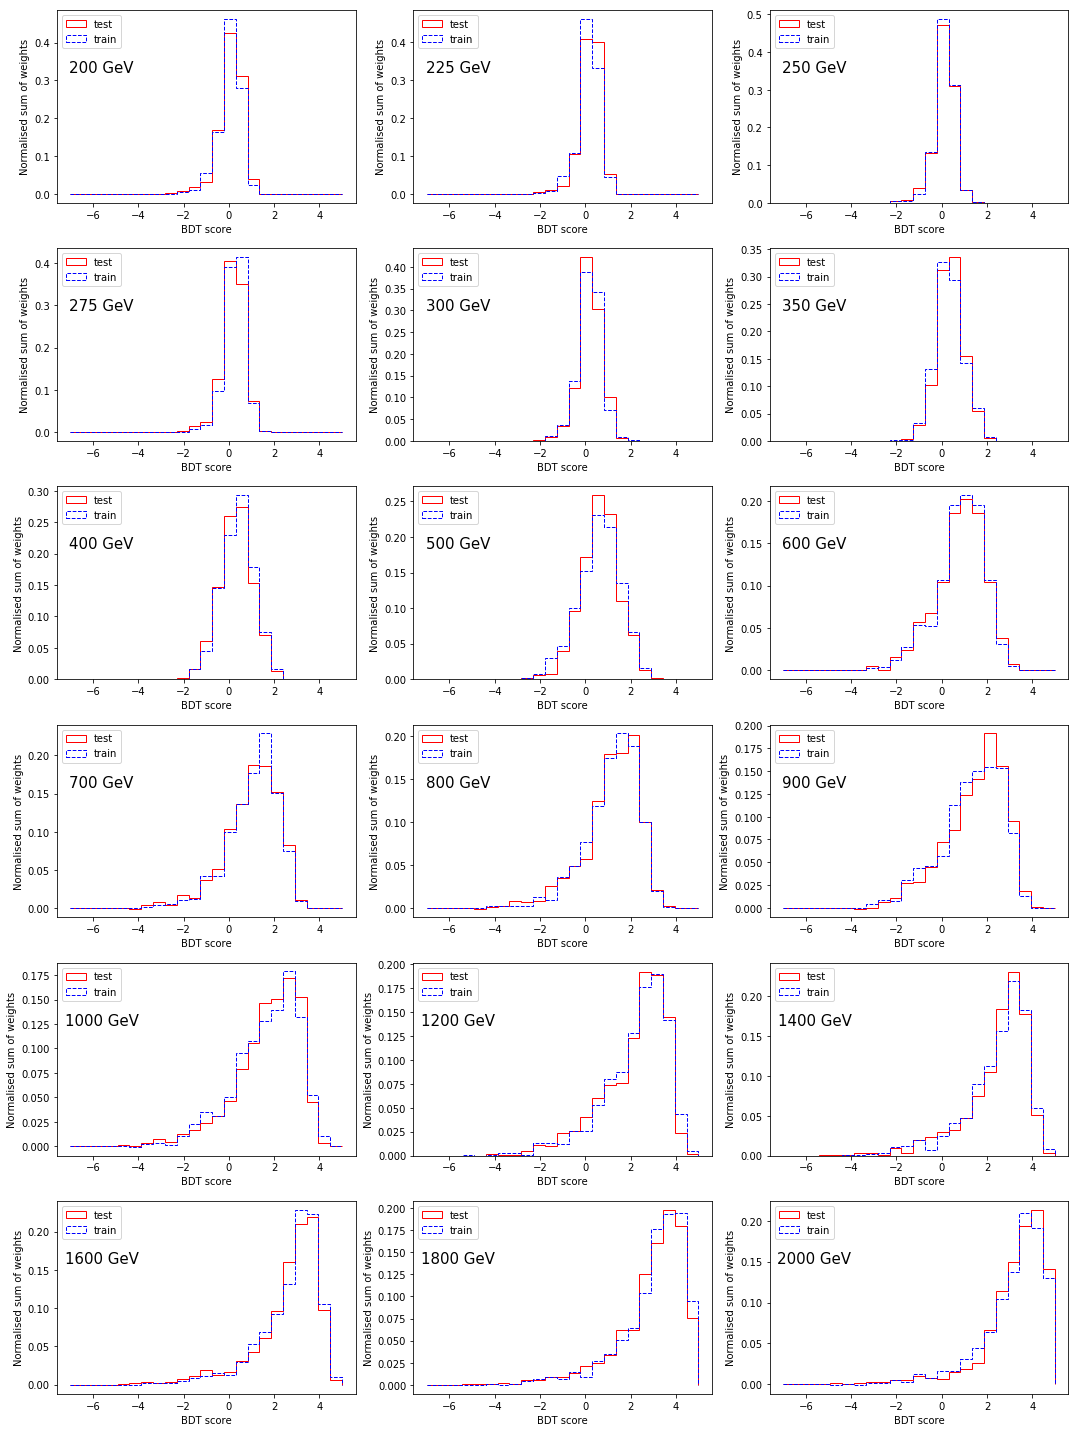

In [29]:
fig, axes=plt.subplots(6,3, figsize=(15, 20))
bins=np.linspace(-10,0,11)

for i,hpmass in enumerate(hpmasses):
    axis=axes[i//3][i%3]
    bins=np.linspace(-7,5,24)
    testmask=test_decfunc.hpmass==hpmass
    trainmask=train_decfunc.hpmass==hpmass
      
    test_weights=test_decfunc[testmask].weight/np.sum(test_decfunc[testmask].weight)
    train_weights=train_decfunc[trainmask].weight/np.sum(train_decfunc[trainmask].weight)
    
        
    axis.hist(test_decfunc[testmask].decfunc.values, bins=bins, ls='-', histtype = 'step',label="test",density=0,color="r", fill=False, linewidth=1, weights=test_weights.values)
    axis.hist(train_decfunc[trainmask].decfunc.values, bins=bins, ls='--', histtype = 'step',label="train",density=0,color="b", fill=False, linewidth=1, weights=train_weights.values)
    
    axis.legend(loc=2)
    axis.set_xlabel("BDT decfunc")
    axis.set_ylabel("Normalised sum of weights")
    axis.text(0.15, 0.7, str(hpmass)+" GeV",transform=axis.transAxes, ha="center", va="center", rotation=0, size=15)

plt.tight_layout()

## now let's use a KDE

### first in 1D

In [30]:
df_mc.weight.shape, (df_mc.weight<0).sum(),(df_mc.weight==0).sum(),(df_mc.weight>0).sum()

((303989,), 101252, 1672, 201065)

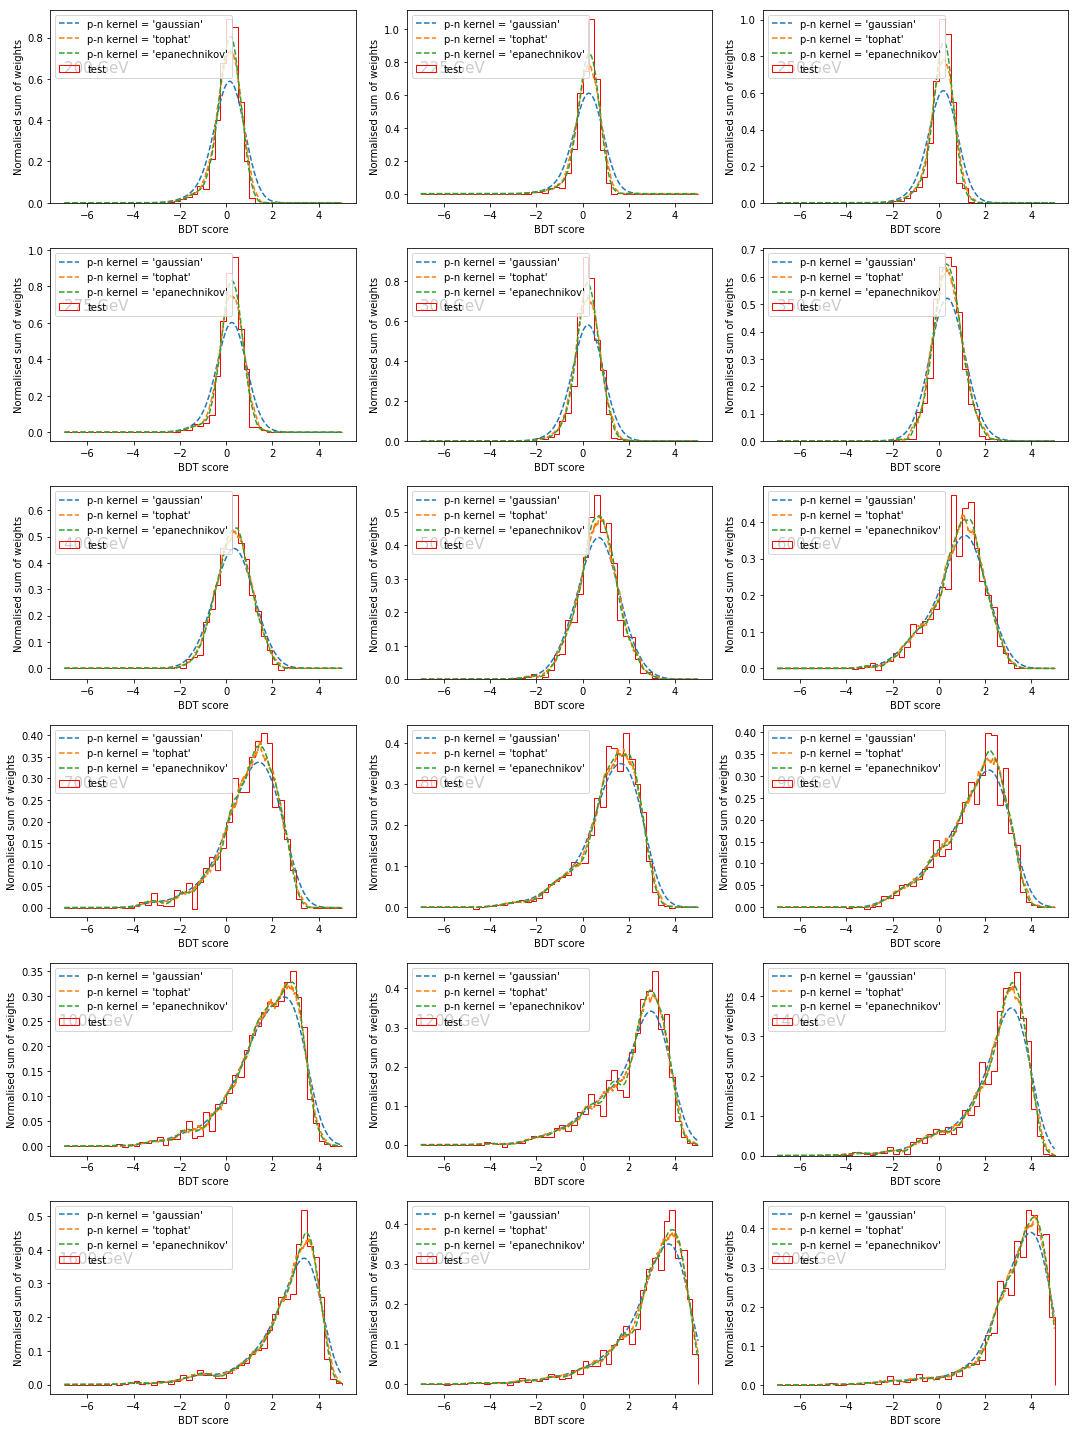

In [85]:
from sklearn.neighbors import KernelDensity
fig, axes=plt.subplots(6,3, figsize=(15, 20))
bins=np.linspace(-7,5,49)
plotx=np.linspace(-6.995,4.995,1200)

for i,hpmass in enumerate(hpmasses):
    axis=axes[i//3][i%3]

    #binned test dataset
    testmask=test_decfunc.hpmass==hpmass
    axis.hist(test_decfunc[testmask].decfunc.values, bins=bins, ls='-', histtype = 'step',label="test",density=1,color="r", fill=False, linewidth=1, weights=test_decfunc[testmask].weight.values)
    
    for kernel in ['gaussian', 'tophat', 'epanechnikov']:
        bandwidth=0.5
        #fit positive and negative weights independently
        kdepos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        pos_test_weights=test_decfunc[testmask & (test_decfunc.weight>0)].weight
        pos_test_values=test_decfunc[testmask & (test_decfunc.weight>0)].decfunc
        kdepos.fit(pos_test_values[:, np.newaxis],y=None,sample_weight=pos_test_weights.values)
        pos_dens = np.exp(kdepos.score_samples(plotx[:, np.newaxis]))
        #axis.plot(plotx, pos_dens, ':', label="kernel = '{0}'".format(kernel))

        kdeneg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        neg_test_weights=abs(test_decfunc[testmask & (test_decfunc.weight<0)].weight)
        neg_test_values=test_decfunc[testmask & (test_decfunc.weight<0)].decfunc
        kdeneg.fit(neg_test_values[:, np.newaxis],y=None,sample_weight=neg_test_weights.values)
        neg_dens = np.exp(kdeneg.score_samples(plotx[:, np.newaxis]))
        #axis.plot(plotx, neg_dens, '--', label="neg kernel = '{0}'".format(kernel))
            
        possum=np.sum(pos_test_weights)
        negsum=np.sum(neg_test_weights)
        dx=plotx[1]-plotx[0]
        
        final_dens=np.maximum(0.,possum*pos_dens-negsum*neg_dens)
        final_dens/=np.sum(final_dens)*dx

        axis.plot(plotx, final_dens, '--', label="p-n kernel = '{0}'".format(kernel))
        
    #axis.hist(train_decfunc[trainmask].decfunc.values, bins=bins, ls='--', histtype = 'step',label="train",normed=0,color="b", fill=False, linewidth=1, weights=train_weights.values)
    
    axis.legend(loc=2)
    axis.set_xlabel("BDT decfunc")
    axis.set_ylabel("Normalised sum of weights")
    axis.text(0.15, 0.4, str(hpmass)+" GeV",transform=axis.transAxes, ha="center", va="center", rotation=0, size=15)

plt.tight_layout()

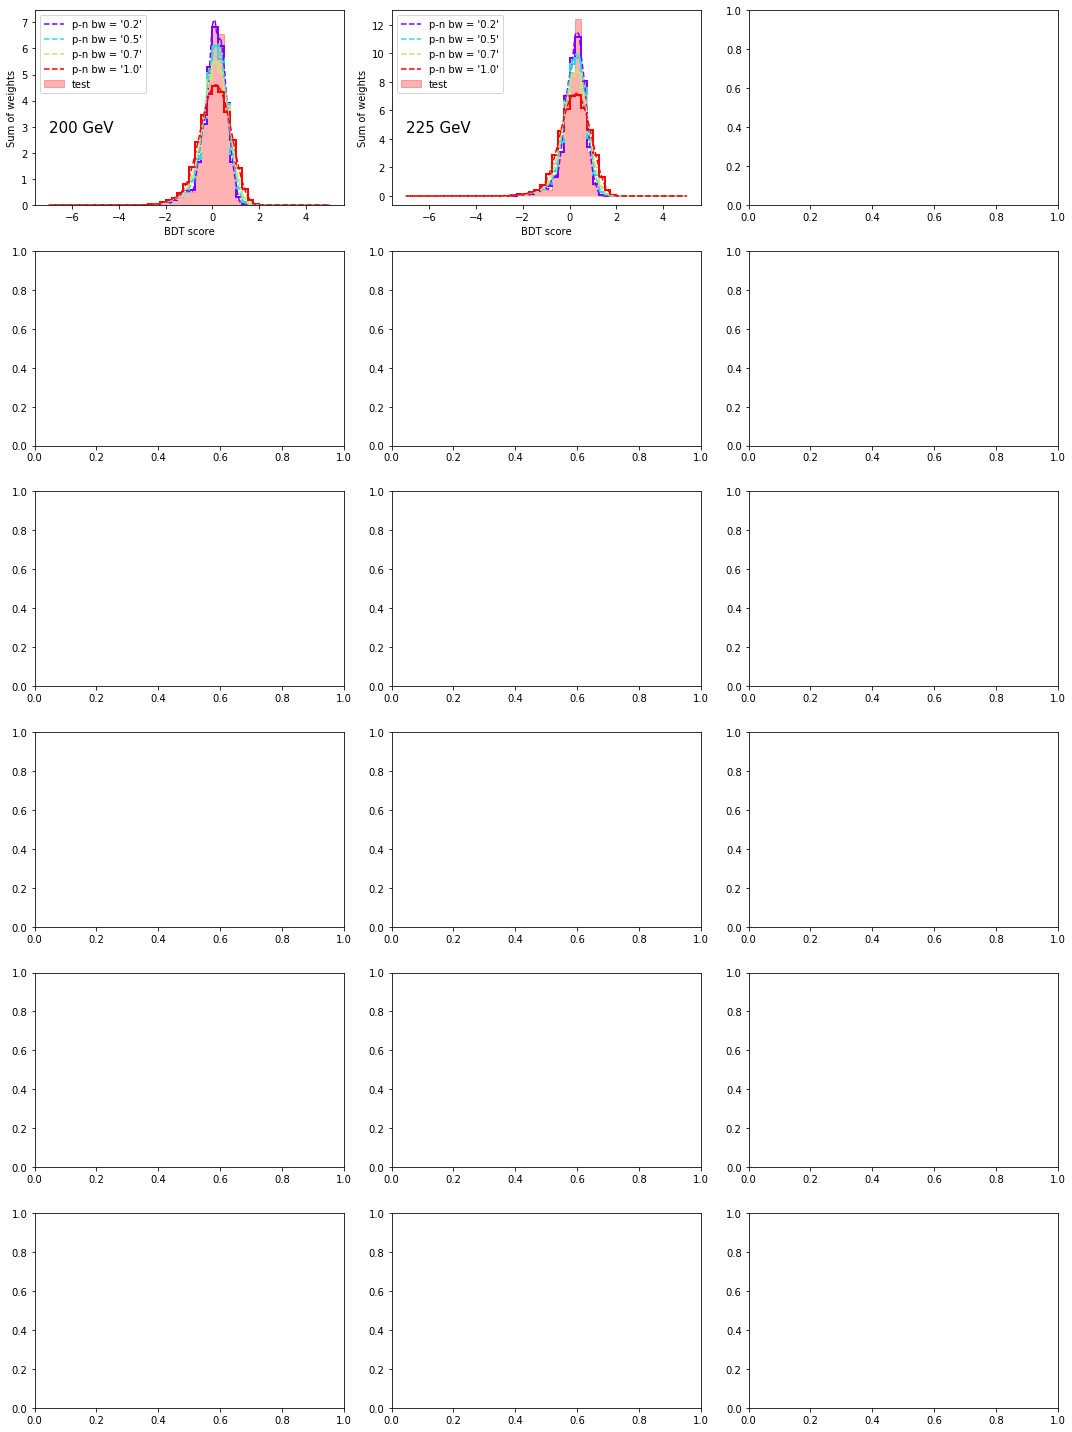

In [135]:
from sklearn.neighbors import KernelDensity
from scipy.stats import binned_statistic

fig, axes=plt.subplots(6,3, figsize=(15, 20))
bins=np.linspace(-7,5,49)
#bins=np.linspace(-7,5,13)
bincenters=[0.5*(bins[i+1]+bins[i]) for i in range(len(bins)-1)]

plotx=np.linspace(-6.995,4.995,1200)

for i,hpmass in enumerate(hpmasses[:2]):
    axis=axes[i//3][i%3]

    #binned test dataset
    testmask=test_decfunc.hpmass==hpmass
    axis.hist(test_decfunc[testmask].decfunc.values, bins=bins, ls='-', histtype = 'step',label="test",color="r", fill=True, alpha=0.3, linewidth=1, weights=test_decfunc[testmask].weight.values)
    #,density=0
    
    kernel='epanechnikov'
    #for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    bandwidths=[0.2,0.5,0.7,1]
    color=iter(plt.cm.rainbow(np.linspace(0,1,len(bandwidths))))

    for bandwidth in bandwidths:
        col=next(color)
        #bandwidth=0.5
        #fit positive and negative weights independently
        kdepos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        pos_test_weights=test_decfunc[testmask & (test_decfunc.weight>0)].weight
        pos_test_values=test_decfunc[testmask & (test_decfunc.weight>0)].decfunc
        kdepos.fit(pos_test_values[:, np.newaxis],y=None,sample_weight=pos_test_weights.values)
        pos_dens = np.exp(kdepos.score_samples(plotx[:, np.newaxis]))
        #axis.plot(plotx, pos_dens, ':', label="kernel = '{0}'".format(kernel))

        kdeneg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        neg_test_weights=abs(test_decfunc[testmask & (test_decfunc.weight<0)].weight)
        neg_test_values=test_decfunc[testmask & (test_decfunc.weight<0)].decfunc
        kdeneg.fit(neg_test_values[:, np.newaxis],y=None,sample_weight=neg_test_weights.values)
        neg_dens = np.exp(kdeneg.score_samples(plotx[:, np.newaxis]))
        #axis.plot(plotx, neg_dens, '--', label="neg kernel = '{0}'".format(kernel))
            
        possum=np.sum(pos_test_weights)
        negsum=np.sum(neg_test_weights)
        dx=plotx[1]-plotx[0]
        dbin=bins[1]-bins[0]
        
        final_dens=np.maximum(0.,possum*pos_dens-negsum*neg_dens)*dx
        
        axis.plot(plotx, final_dens*dbin/dx, '--', label="p-n bw = '{0:.1f}'".format(bandwidth), color=col)
        
        (stat,_,_)=binned_statistic(plotx, final_dens, statistic='sum', bins=bins)
        #axis.hist(bincenters, bins=bins, ls='-', histtype = 'step',label="p-n bw = '{0:.1f}'".format(bandwidth), color=col, fill=False, linewidth=2, weights=stat)
        axis.hist(bincenters, bins=bins, ls='-', histtype = 'step', color=col, fill=False, linewidth=2, weights=stat)

    
    axis.legend(loc=2)
    axis.set_xlabel("BDT decfunc")
    axis.set_ylabel("Sum of weights")
    axis.text(0.15, 0.4, str(hpmass)+" GeV",transform=axis.transAxes, ha="center", va="center", rotation=0, size=15)

plt.tight_layout()

let's take an epanechnikov kernel with bandwidth 0.5

### now in 2D

[-7.   -6.75 -6.5  -6.25 -6.   -5.75 -5.5  -5.25 -5.   -4.75 -4.5  -4.25
 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.   -1.75 -1.5  -1.25
 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25  1.5   1.75
  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75
  5.  ] [187.5, 212.5, 237.5, 262.5, 287.5, 325.0, 375.0, 450.0, 550.0, 650.0, 750.0, 850.0, 950.0, 1100.0, 1300.0, 1500.0, 1700.0, 1900.0, 2100.0]


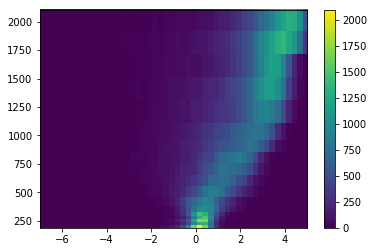

In [118]:
from sklearn.neighbors import KernelDensity
data=test_decfunc[['decfunc','hpmass']]
binsx=np.linspace(-7,5,49)
diffs=[hpmasses[i+1]-hpmasses[i] for i in range(len(hpmasses)-1)]
binsy=[hpmasses[0]-diffs[0]/2]
for i in range(len(diffs)):
    binsy.append(hpmasses[i]+diffs[i]/2)
binsy.append(hpmasses[-1]+diffs[-1]/2)
print(binsx,binsy)

plt.figure()
plt.hist2d(test_decfunc['decfunc'].values, test_decfunc['hpmass'].values, bins=(binsx,binsy))
plt.colorbar()
#axis.hist(test_decfunc[testmask].decfunc.values, bins=bins, ls='-', histtype = 'step',label="test",density=1,color="r", fill=False, linewidth=1, weights=test_decfunc[testmask].weight.values)

#ax.hist2d(data[:, 0], data[:, 1], bins=100, norm=mcolors.PowerNorm(gamma))
#axis.hist(test_decfunc[testmask].decfunc.values, bins=bins, ls='-', histtype = 'step',label="test",density=1,color="r", fill=False, linewidth=1, weights=test_decfunc[testmask].weight.values)

#kernel='epanechnikov'
#bandwidth=0.5
#kdepos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
#pos_test_weights=test_decfunc[testmask & (test_decfunc.weight>0)].weight
#pos_test_values=test_decfunc[testmask & (test_decfunc.weight>0)][['decfunc','hpmass']]
#kdepos.fit(pos_test_values[:, np.newaxis],y=None,sample_weight=pos_test_weights.values)
#pos_dens = np.exp(kdepos.score_samples(plotx[:, np.newaxis]))





# Use the mass parameterised BDT score trained at N-1 masses

In [46]:
bins=np.linspace(-7,0,15)
print bins

[-7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5
  0. ]


# Old stuff for reference

split into test and training data

In [0]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc) 

In [160]:
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=800)
summarizeFitData(X_train, y_train, w=w_train)

sb=MultiSBWeightsScaler(backgroundclass=0)
sb.fit(X_train,y_train, sample_weight=w_train)
X_train=sb.transform(X_train,y_train, sample_weight=w_train)
X_test=sb.transform(X_test,y_test, sample_weight=w_test)
#w_train.groupby(y_train).sum()
summarizeFitData(X_train, y_train, w=w_train)

wss=WeightedStandardScaler()
wss.fit(X_train,sample_weight=w_train)
X_train=wss.transform(X_train)
X_test=wss.transform(X_test)
#X_eval=wss.transform(X_eval)
summarizeFitData(X_train, y_train, w=w_train)
summarizeFitData(X_test, y_test, w=w_test)

X.shape= (23068, 14) y.shape= (23068,) w.shape= (23068,)
columns= Index([u'nJets', u'nBTags_70', u'pT_jet1', u'Mbb_MindR_70', u'pT_jet5',
       u'H1_all', u'dRbb_avg_70', u'dRlepbb_MindR_70', u'Muu_MindR_70',
       u'HT_jets', u'Mbb_MaxPt_70', u'Mbb_MaxM_70', u'Mjjj_MaxPt',
       u'Centrality_all'],
      dtype='object')
categories= [0, 1]

sum of weights per category
       all 1464.08896891
         0 1457.10675797
         1 6.98221093499


average
  variable/class        all          0          1
           nJets       6.99       6.99       7.43
       nBTags_70       4.06       4.06        4.1
         pT_jet1   1.77e+05   1.77e+05   2.96e+05
    Mbb_MindR_70   7.76e+04   7.73e+04   1.33e+05
         pT_jet5   5.06e+04   5.05e+04   6.68e+04
          H1_all      0.226      0.227      0.182
     dRbb_avg_70       2.28       2.28       2.42
dRlepbb_MindR_70       2.31       2.31       2.17
    Muu_MindR_70   1.05e+05   1.05e+05   1.06e+05
         HT_jets   5.69e+05   5.68e+05   